In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import spacy
import neuralcoref
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

en_spacy = spacy.load("en_core_web_lg")
neuralcoref.add_to_pipe(en_spacy)

def resolve_coref(text):
    text = text.replace("\n", " ").replace("  ", " ").strip()
    doc = en_spacy(text)
    return doc._.coref_resolved

def filter_spans(doc):
    spans = list(doc.ents) + list(doc.noun_chunks)
    spans = spacy.util.filter_spans(spans)
    with doc.retokenize() as retokenizer:
        for span in spans:
            retokenizer.merge(span)
    return doc

In [3]:
def extract_is_rel(t, nodes, KG):
    _nodes = []
    for n in list(t.children):
        if len(n) > 2:
            _nodes.append(n)
            if str(n) not in nodes:
                nodes.append(str(n))
                KG.add_node(str(n))
    try:
        assert len(_nodes) == 2
    except:
        pass
    try:
        return str(_nodes[0]), str(_nodes[1])
    except:
        return None, None

def extract_in_rel(t, nodes, persons, KG):
    _nodes = []
    src, dst = None, None
    for n in list(t.children):
        if len(n) > 1:
            _nodes.append(n)
            if str(n) not in nodes:
                nodes.append(str(n))
                KG.add_node(str(n))
    if len(_nodes) > 0:
        _node = _nodes[0]
        terminate = False
        counter = 0
        _t = t.head
        while not terminate and counter < len(nodes):
            if str(_t) in nodes:
                terminate = True
            elif str(_t) == str(_t.head):
                terminate = True
            else:
                _t = _t.head
                counter += 1
        if str(_t) not in nodes:
            for ci in list(_t.children):
                if str(ci) in nodes:
                    _t = ci
                    break
                for cj in list(ci.children):
                    if str(cj) in nodes:
                        _t = cj
                        break
        if str(_t) in nodes and str(_t) != str(_node):
            src = _t
            dst = _node
            if str(_node) in persons:
                src = _node
                dst = _t
    return src, dst

def extract_relation(text):
    KG = nx.DiGraph()
    doc = en_spacy(text)
    doc = filter_spans(doc)
    prev_ent = None
    nodes = []
    persons = []
    for t in doc:
        if prev_ent != t.ent_type_ and t.ent_type_ is not "":
            # new entity/chunk
            if str(t) not in nodes:
                nodes.append(str(t))
                KG.add_node(str(t))
            if t.ent_type_ == "PERSON" and str(t) not in persons:
                persons.append(str(t))
            prev_ent = t.ent_type_
        if str(t) in ["is", "was", "are", "were"]:
            src, dst = extract_is_rel(t, nodes, KG)
            if src and dst:
                KG.add_edges_from([(src, dst, {"r": "IS"})])
        if t.pos_ == "ADP":
            src, dst = extract_in_rel(t, nodes, persons, KG)
            if src and dst:
                KG.add_edges_from([(str(src), str(dst), {"r": "IN"})])
    print(nodes)
    return KG

In [6]:
TEXT_1 = """
Gennaro Basile was an Italian painter, born in Naples but active in the German-speaking countries. 
He settled at Brünn, in Moravia, and lived about 1756. 
His best picture is the altar-piece in the chapel of the chateau at Seeberg, in Salzburg. 
Most of his works remained in Moravia. 
This article about an Italian painter born in the 18th century is a stub.
"""

TEXT_2 = """
SUTD is the fourth autonomous university in Singapore, next to Upper Changi MRT station. 
Its founding president is Thomas L. Magnanti, who is a Professor associated with the Massachusetts Institute of Technology (MIT). 
Its permanent campus, which opened in January 2015, is located near the Changi Business Park, and is served by Upper Changi Station on the Downtown MRT Line. 
As of 2018, it is the only university to be located in the eastern part of Singapore. 
Its permanent campus is in Upper Changi.
"""

TEXT_3 = """
Lee Hsien Loong is a Singaporean politician serving as the current and third Prime Minister of Singapore since 2004. 
Lee is the eldest son of Singapore's first Prime Minister, Lee Kuan Yew. 
In 1971, he was awarded a President's Scholarship and Singapore Armed Forces Overseas Scholarship by the Public Service Commission to study mathematics at Trinity College, University of Cambridge. 
He was Senior Wrangler in 1973, and graduated in 1974 with first-class honours on a Bachelor of Arts in Mathematics and a Diploma in Computer Science with distinction. 
In 1980, he completed a Master of Public Administration at the John F. Kennedy School of Government, Harvard University.
"""

TEXTS = [TEXT_1, TEXT_2, TEXT_3]


Gennaro Basile was an Italian painter, born in Naples but active in the German-speaking countries. Gennaro Basile settled at Brünn, in Moravia, and lived about 1756. Gennaro Basile best picture is the altar-piece in the chapel of the chateau at Seeberg, in Salzburg. Most of Gennaro Basile works remained in Moravia. This article about an Italian painter born in the 18th century is a stub.
['Gennaro Basile', 'an Italian painter', 'Naples', 'the German-speaking countries', 'Brünn', 'Moravia', 'about 1756', 'Gennaro Basile best picture', 'the altar-piece', 'the chapel', 'the chateau', 'Seeberg', 'Salzburg', 'the 18th century', 'This article', 'a stub']


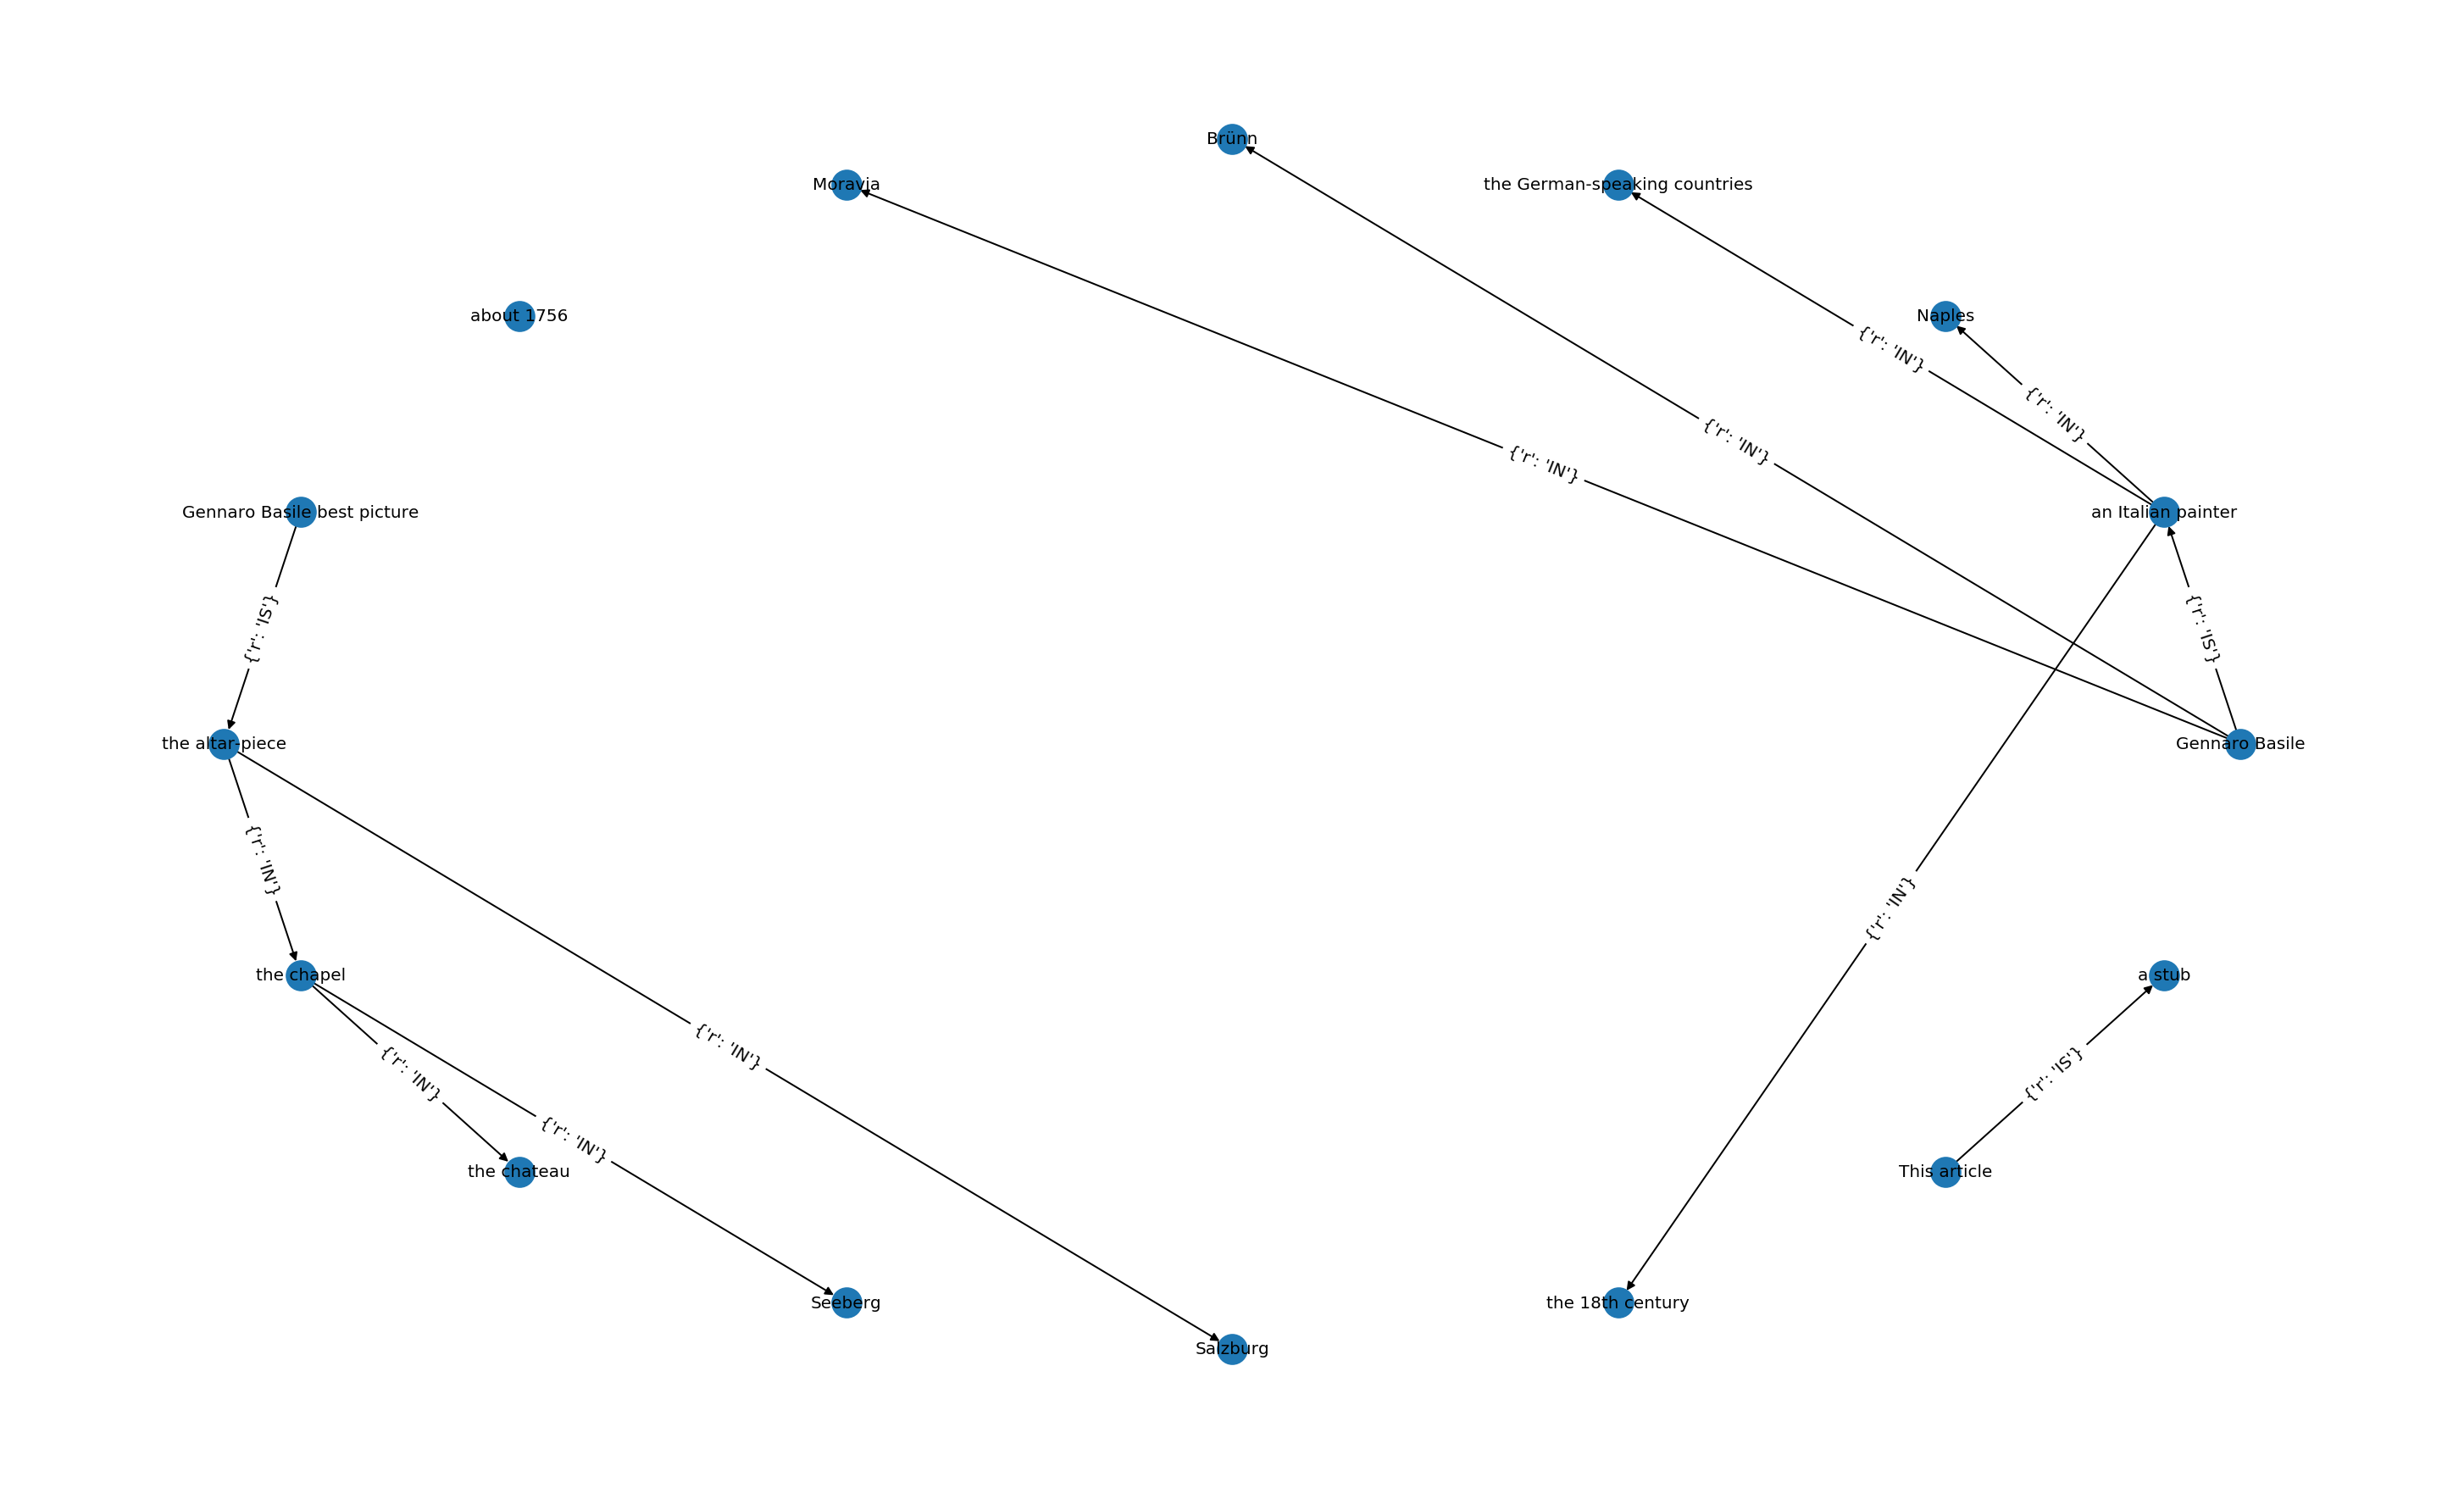



SUTD is the fourth autonomous university in Singapore, next to Upper Changi MRT station. SUTD founding president is Thomas L. Magnanti, who is a Professor associated with the Massachusetts Institute of Technology (MIT). SUTD permanent campus, which opened in January 2015, is located near the Changi Business Park, and is served by Upper Changi Station on the Downtown MRT Line. As of 2018, it is the only university to be located in the eastern part of Singapore. SUTD permanent campus is in Upper Changi.
['SUTD', 'the fourth autonomous university', 'next', 'Singapore', 'Upper Changi MRT station', 'SUTD founding president', 'Thomas L. Magnanti', 'who', 'a Professor', 'the Massachusetts Institute of Technology', 'January 2015', 'the Changi Business Park', 'Upper Changi Station', 'the Downtown MRT Line', 'of', '2018', 'the only university', 'the eastern part', 'permanent campus', 'Upper Changi']


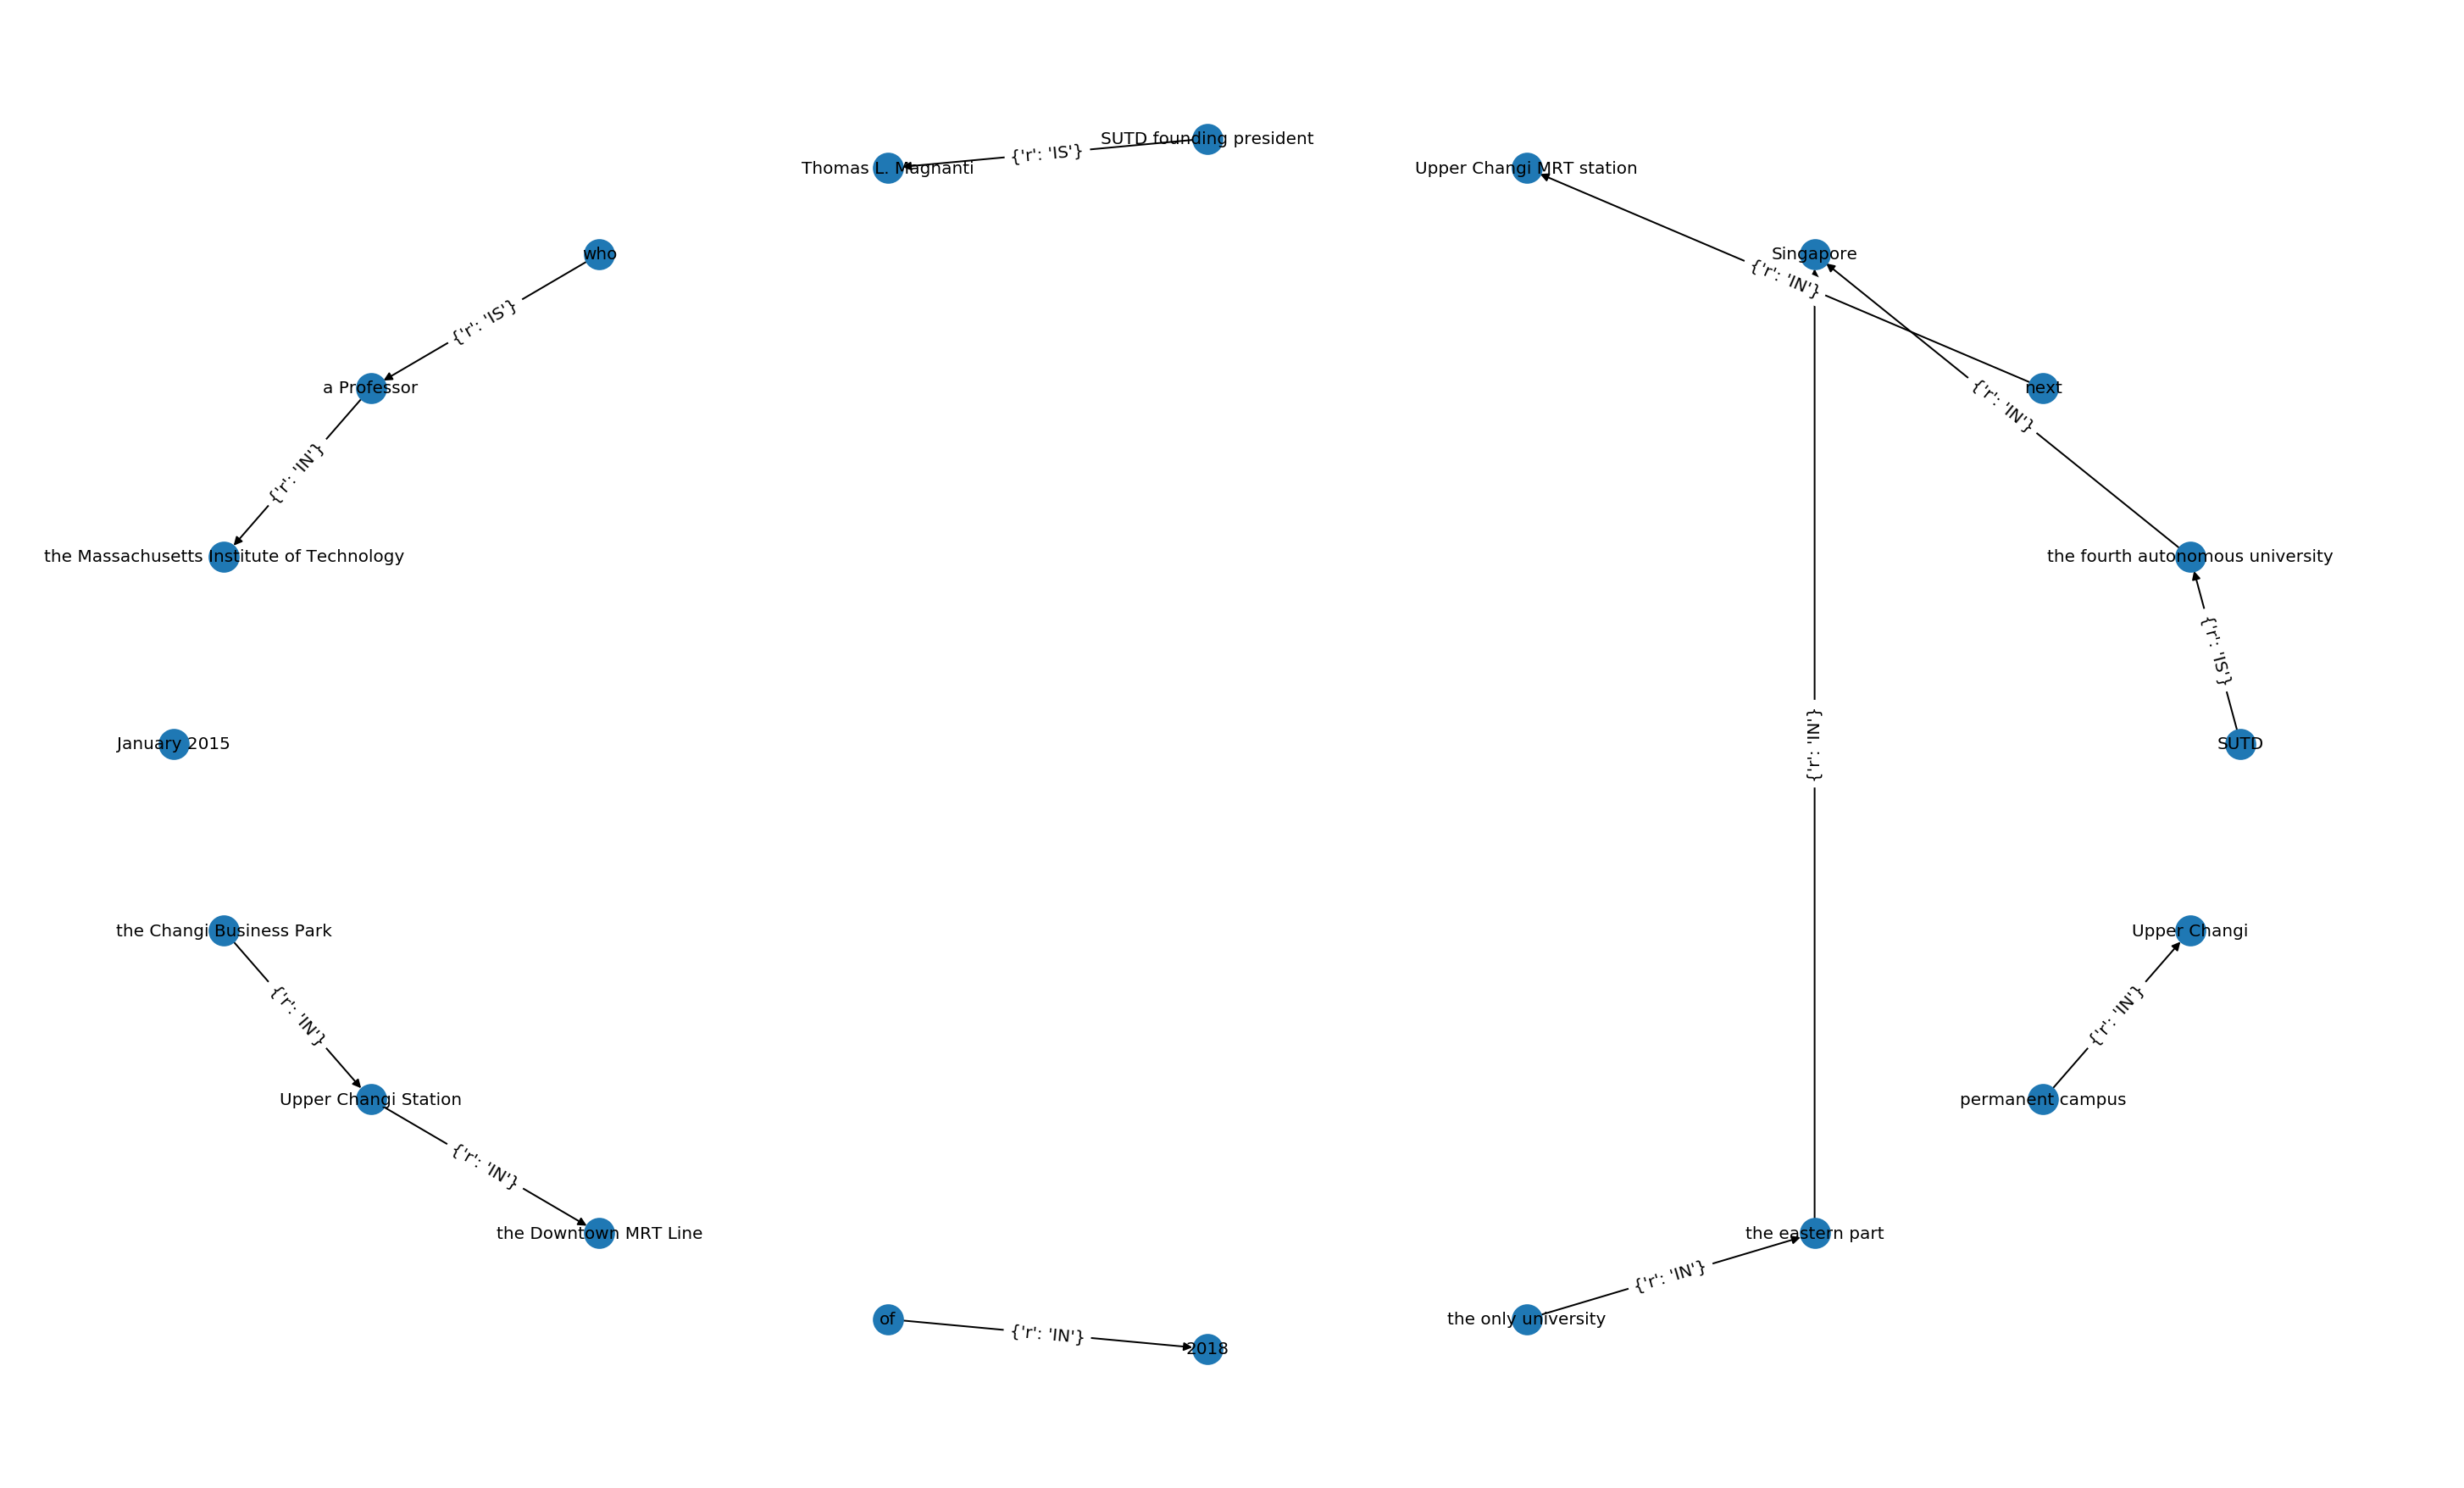



Lee Hsien Loong is a Singaporean politician serving as the current and third Prime Minister of Singapore since 2004. Lee Hsien Loong is the eldest son of Singapore's first Prime Minister, Lee Kuan Yew. In 1971, Lee Hsien Loong was awarded a President's Scholarship and Singapore Armed Forces Overseas Scholarship by the Public Service Commission to study mathematics at Trinity College, University of Cambridge. Lee Hsien Loong was Senior Wrangler in 1973, and graduated in 1974 with first-class honours on a Bachelor of Arts in Mathematics and a Diploma in Computer Science with distinction. In 1980, Lee Hsien Loong completed a Master of Public Administration at the John F. Kennedy School of Government, Harvard University.
['Lee Hsien Loong', 'a Singaporean politician', 'current', 'third Prime Minister', 'Singapore', '2004', 'the eldest son', "Singapore's first Prime Minister", 'Lee Kuan Yew', '1971', 'Singapore Armed Forces Overseas Scholarship', 'the Public Service Commission', 'Trinity 

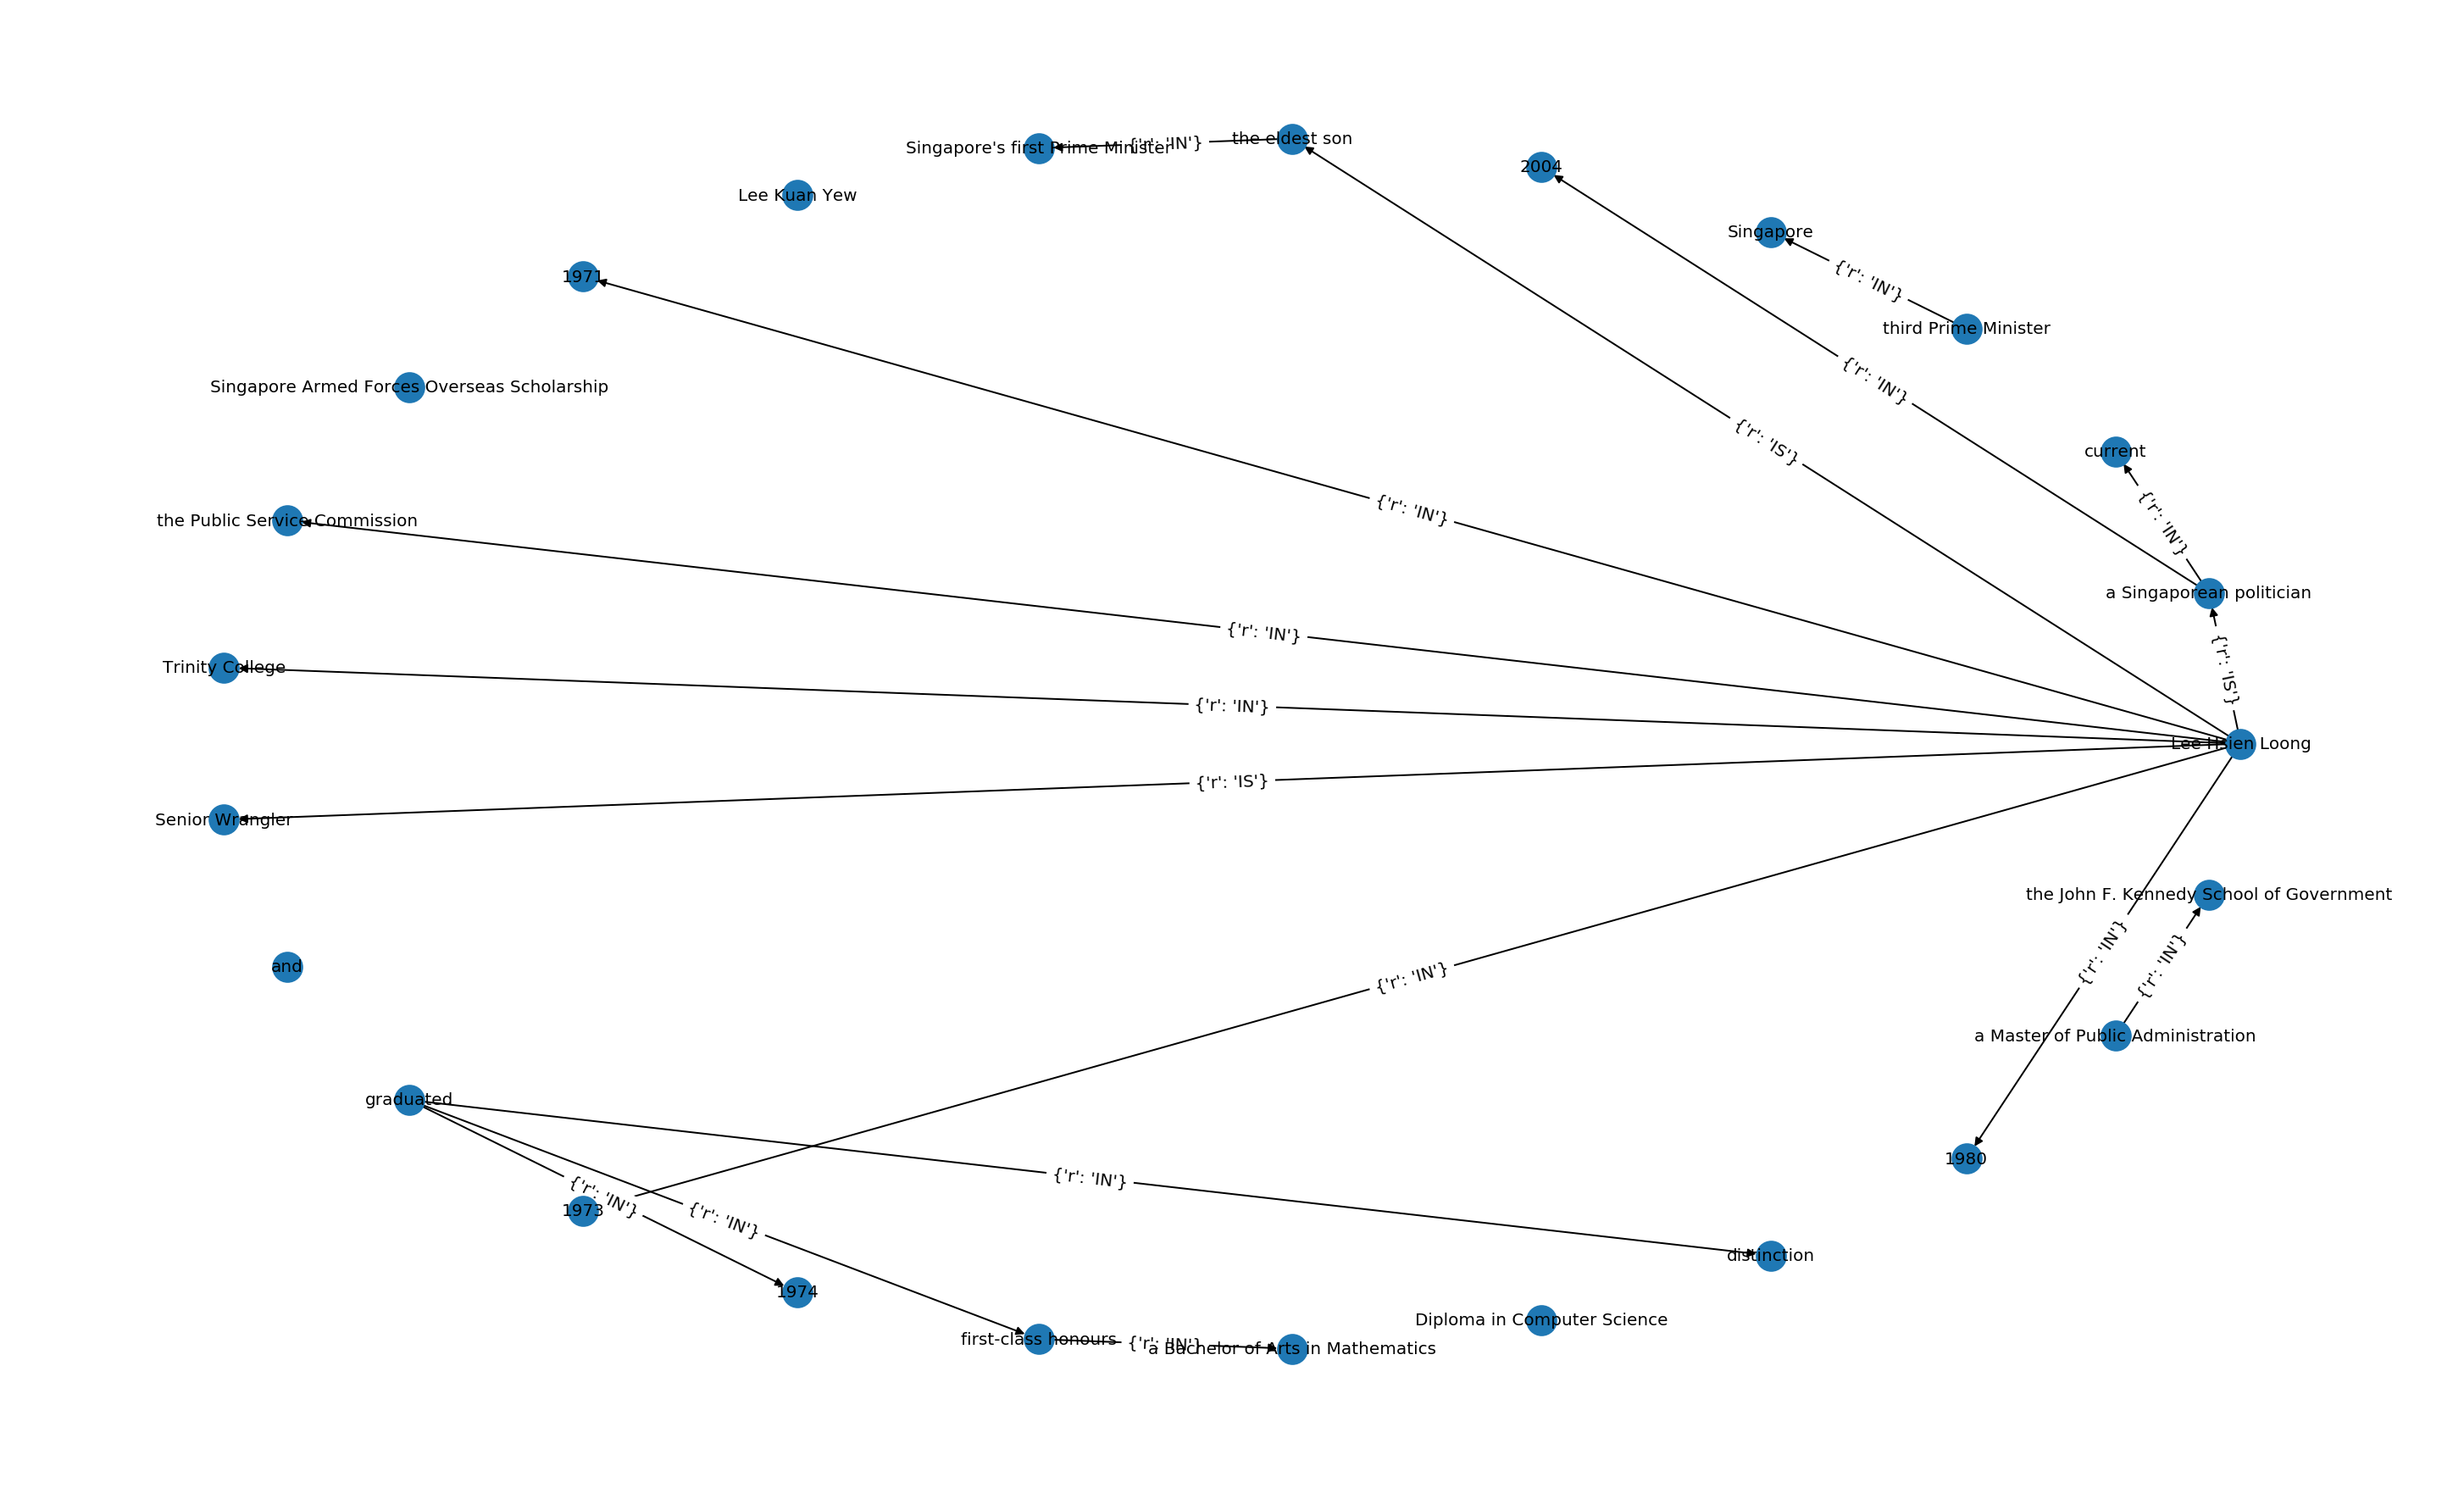

In [7]:
for text in TEXTS:
    print("")
    text_coref = resolve_coref(text)
    print(text_coref)
    KG = extract_relation(text_coref)
    plt.figure(figsize=(20,12))
    nx.draw_shell(KG, with_labels=True, font_size=10)
    nx.draw_networkx_edge_labels(KG, pos=nx.shell_layout(KG), font_size=10)
    plt.show()
    print("")